In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')

# Import useful functions for this script  
from tracking import track

track("-"*25 + "CLUSTERING" + "-"*25)

# Reading data

#### Define path to data files

In [14]:
track("Defining path to data files")

# Define base path to data files
path = '../../temp_data/'

# Define path to the table that will be used in this project
path_preprocess_data = path + 'model_data.csv'

# Ensure the input file exist
assert os.path.isfile(path_preprocess_data), f'{path_preprocess_data} not found. Is it a file?'

#### Read the files

In [15]:
# Read model_data table
track("Reading files")
preprocess_data = pd.read_csv(path_preprocess_data)
track("Finished reading files")

In [16]:
# Drop the column author name
data = preprocess_data.iloc[:,2:len(preprocess_data.columns)]

# Model

In [66]:
def save_plot(fig,type_model,filename):
    '''
    Objective:
        - Save plots
    Input:
        - fig: Figure we want to save
        - type_model: K-means
        - filename: Name of the file 
    Output:
        - None
    '''  
    # Path and name of the file/figure we want to save
    path = '../../reports/figures/models'+"/"+type_model
    file_name = path+"/"+filename+".png"
    # Directory creation if doesn't exists
    try:
        os.makedirs(path)
    except OSError:
        pass
    else:
        track("Successfully created the directory %s" % path)

    # Save the figure/file
    if (os.path.exists(file_name)== True):
        track ("Warning: Figure %s already created" % path)
        track('Figure will be overwritten')
        plt.savefig(file_name, transparent=True)
    else:
        plt.savefig(file_name, transparent=True)
    track("Successfully saved %s" % path)

def normalize_data(data):
    '''
    Objective:
        - Normalize data with the MinMaxScaler method
    Input:
        - dataset: Pandas dataframe 
    Output:
        - min_max_Scalar_df: Normalized data
    '''    
    min_max_Scalar = preprocessing.MinMaxScaler()
    col = data.columns
    result = min_max_Scalar.fit_transform(data)
    min_max_Scalar_df = pd.DataFrame(result, columns=col)
    return min_max_Scalar_df

def f_silhouette_score(dataset,total_clusters):
    '''
    Objective:
        - Compute the silhouette_score
    Input:
        - dataset: Normalized dataframe 
        - total_clusters: Maximum number of clusters
    Output:
        - Number of clusters that has the biggest value of silhouette_score
    '''       
    max_value = 0
    k = 0
    for n_cluster in range(2, total_clusters):
        kmeans = KMeans(n_clusters=n_cluster).fit(dataset)
        label = kmeans.labels_
        sil_coeff = silhouette_score(dataset, label, metric='euclidean')
        if sil_coeff > max_value:
            max_value = sil_coeff
            k = n_cluster
        track("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    print("silhouette_score", max_value)
    return k

def WCSS_and_Elbow_Method(dataset,total_k):
    '''
    Objective:
        - Compute the WCSS_and_Elbow_Method
    Input:
        - dataset: Normalized dataframe 
        - total_clusters: Maximum number of clusters
    Output:
        - Save the plot of number of clusters vs inertia
    '''        
    wcss=[]
    # smaller_intertia = 1000000000000000
    # k = 0
    for i in range(1,total_k):
        # Kmeans with i clusters
        kmeans = KMeans(i)
        kmeans.fit(dataset)
        # Compute the inertia
        inertia = kmeans.inertia_        
        # Save the value of the smaller inertia

        # if inertia < smaller_intertia and inertia > 1:  # CHANGEE NUMBER OF INERTIAAA !!!!!!
        #     smaller_intertia = inertia
        #     k = i

        # Save the inertia of each iteration
        wcss.append(inertia)  

    # Plot the number of clusters vs inertia 
    number_clusters = range(1,total_k)
    fig = plt.plot(number_clusters,wcss, 'bx-')
    plt.title('WCSS and Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS (Elbow Method For Optimal k)')
    save_plot(fig,"K-means",'WCSS_and_Elbow_Method')


def define_num_clusters(dataset,total_k):
    '''
    Objective:
        - Compute the optimal number of clusters with WCSS and Elbow Method and silhouette_score
    Input:
        - dataset: Normalized dataframe 
        - total_k : Maximum number of clusters to be used 
    Output:
        - The cluster number of each row
    '''
    # Compute the inertia and plot the graphic between insertia ans number of clusters
    WCSS_and_Elbow_Method(dataset,total_k)

    # Choosing the number of clusters with the silhouette_score
    number_of_clusters = f_silhouette_score(dataset,total_k)
    
    #Once selected the number of clusters, compute the cluster of each row and added to the dataframe
    kmeans = KMeans(number_of_clusters)
    kmeans.fit(dataset)
    identified_clusters = kmeans.fit_predict(dataset)
    iner = kmeans.inertia_
    print("total inertia", iner)
    print("Number of clusters", number_of_clusters)
    return (identified_clusters,number_of_clusters)

def Compute_PCA(dataset):
    '''
    Objective:
        - Compute PCA 
    Input:
        - dataset: Normalized dataframe 
    Output:
        - PCA data
    '''
    track('Performing PCA on dataset ...')
    # Take the number of components that explain more than a 0.955% of the variance
    for i in range(len(dataset.columns)):
        pca = PCA(n_components=i)
        principal_components = pca.fit_transform(dataset)
        if (sum(pca.explained_variance_ratio_) > 0.955):
            n = i
            track("PCA components:{}".format(n))
            break
        
    # Compute the pca with the number of components chosen
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(dataset)
    pca_df = pd.DataFrame(data = principal_components)
    track("explained variance in PCA:{}".format(sum(pca.explained_variance_ratio_)))
    print("explained variance in PCA:{}".format(sum(pca.explained_variance_ratio_)))    # borrar aquesta i al següent linea
    print("PCA components:{}".format(n))
    return pca_df


#### K-means with normalized data

In [73]:
track("Starting normalizing data")
# Normalize data
normalize_data = normalize_data(data)
track("Finished normalizing data")

silhouette_score 0.6787093724910817
total inertia 143.2709997465127
Number of clusters 2


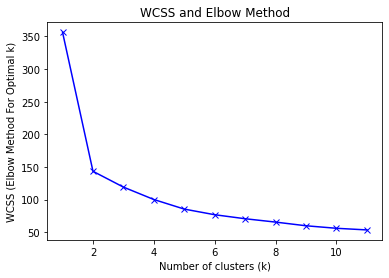

In [36]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters, number_of_clusters = define_num_clusters(normalize_data,12)
track("Finished WCSS and Elbow method for choosing the number of clusters")

In [49]:
total_eachcluster = []
for k in range(number_of_clusters):
    total_eachcluster.append(sum((clusters==k)))

print(total_eachcluster)

[26, 218]


In [13]:
# PER FER PROVES !!!!!!

# Once selected the number of clusters, compute the cluster of each row and added to the dataframe
kmeans = KMeans(5)
kmeans.fit(normalize_data)
identified_clusters = kmeans.fit_predict(normalize_data)
iner = kmeans.inertia_
print(iner)
len(identified_clusters)

85.14693814886706


244

In [22]:
# PER FER PROVES !!!!
for n_cluster in range(2, 30):
    kmeans = KMeans(n_clusters=n_cluster).fit(normalize_data)
    label = kmeans.labels_
    sil_coeff = silhouette_score(normalize_data, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.6787093724910817
For n_clusters=3, The Silhouette Coefficient is 0.408731182714735
For n_clusters=4, The Silhouette Coefficient is 0.3426616600401511
For n_clusters=5, The Silhouette Coefficient is 0.3125093641594285
For n_clusters=6, The Silhouette Coefficient is 0.29855516470057775
For n_clusters=7, The Silhouette Coefficient is 0.2867424581822193
For n_clusters=8, The Silhouette Coefficient is 0.2966464492300953
For n_clusters=9, The Silhouette Coefficient is 0.25463047931517524
For n_clusters=10, The Silhouette Coefficient is 0.3042233473825171
For n_clusters=11, The Silhouette Coefficient is 0.2684266336112148
For n_clusters=12, The Silhouette Coefficient is 0.3105462057979438
For n_clusters=13, The Silhouette Coefficient is 0.2767946376468303
For n_clusters=14, The Silhouette Coefficient is 0.2592712592014957
For n_clusters=15, The Silhouette Coefficient is 0.2919407907698758
For n_clusters=16, The Silhouette Coefficient is 0.2790

#### K-means with PCA data

In [54]:
# Compute PCA
Compute_PCA(normalize_data)
print('Performing PCA on dataset ...')
pca = PCA(n_components=10)
principal_components = pca.fit_transform(normalize_data)
pca_df = pd.DataFrame(data = principal_components)
sum(pca.explained_variance_ratio_)

Performing PCA on dataset ...


0.9557306910863511

In [77]:
# Compute PCA
track("Starting to compute PCA")
PCA_data = Compute_PCA(normalize_data)
track("Finished computing PCA")

explained variance in PCA:0.9557306910863511


silhouette_score 0.6980355103232093
total inertia 127.5309117049738
Number of clusters 2


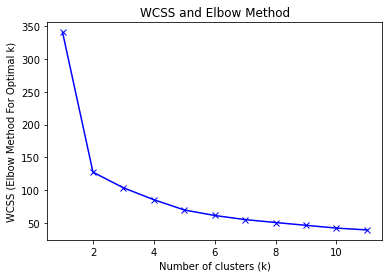

In [78]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters, number_of_clusters = define_num_clusters(pca_df,12)
track("Finished WCSS and Elbow method for choosing the number of clusters")